## Image Sequence Data Generator

In [1]:
working_dir = "/Volumes/Samsung_T5/WeatherNet"

In [2]:
# A. General
import os

# B. Datafile manipulation
from PIL import Image
import pandas as pd
import glob 

# C. Numeric operations
import numpy as np 
from random import shuffle
from itertools import chain

# D. DataGenerator
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical

# E. Plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
os.chdir(working_dir) # Change working dir to working_dir path
os.system("dot_clean ") # Remove ._ files if mac or linux

# Declare dir that holds data
data_dir = working_dir + "/data"

# Declare train data path
train_flir_path = data_dir+"/train/flir"
train_bottom_path = data_dir+"/train/bottom"
train_top_path = data_dir+"/train/top"

# Declare val data path
val_flir_path = data_dir+"/val/flir"
val_bottom_path = data_dir+"/val/bottom"
val_top_path = data_dir+"/val/top"

# Declare test data path
test_flir_path = data_dir+"/test/flir"
test_bottom_path = data_dir+"/test/bottom"
test_top_path = data_dir+"/test/top"

## Sequence Image Data Generator

In [4]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self,flir_dir, bottom_dir, top_dir, n_frames,\
                      n_batches, img_height,img_width, labels,shuffle,n_channels=3):
        'Initialization'        
        self.flir_dir = flir_dir
        self.bottom_dir = bottom_dir
        self.top_dir = top_dir      
        
        self.img_height = img_height
        self.img_width = img_width
        self.batch_size = n_batches
        self.n_frames = n_frames
        
        self.n_channels = n_channels
        self.labels = labels
        self.n_classes = len(self.labels)
        self.shuffle = shuffle
           
        self.flir_low_pics = glob.glob(flir_dir+"/low/*.jpg")
        self.flir_mid_pics = glob.glob(flir_dir+"/mid/*.jpg")
        self.flir_high_pics = glob.glob(flir_dir+"/high/*.jpg")
        self.flir_low_pics.sort()
        self.flir_mid_pics.sort()
        self.flir_high_pics.sort()
        
        self.bottom_low_pics = glob.glob(bottom_dir+"/low/*.jpg")
        self.bottom_mid_pics = glob.glob(bottom_dir+"/mid/*.jpg")
        self.bottom_high_pics = glob.glob(bottom_dir+"/high/*.jpg")    
        self.bottom_low_pics.sort()
        self.bottom_mid_pics.sort()
        self.bottom_high_pics.sort()
        
        self.top_low_pics = glob.glob(top_dir+"/low/*.jpg")
        self.top_mid_pics = glob.glob(top_dir+"/mid/*.jpg")
        self.top_high_pics = glob.glob(top_dir+"/high/*.jpg")
        self.top_low_pics.sort()
        self.top_mid_pics.sort()
        self.top_high_pics.sort()
        
        # group low samples
        self.top_low_sets = [self.top_low_pics[i:i+self.n_frames] for i in range(0, \
                                        len(self.top_low_pics), self.n_frames)]
        self.bottom_low_sets = [self.bottom_low_pics[i:i+self.n_frames] for i in range(0, \
                                        len(self.bottom_low_pics), self.n_frames)]
        self.flir_low_sets = [self.flir_low_pics[i:i+self.n_frames] for i in range(0, \
                                        len(self.flir_low_pics), self.n_frames)] 
        self.low_sets = []
        for i in range(len(self.flir_low_sets)):
            self.low_sets.append([self.flir_low_sets[i],self.bottom_low_sets[i],\
                                 self.top_low_sets[i]])
            
        # group mid samples
        self.top_mid_sets = [self.top_mid_pics[i:i+self.n_frames] for i in range(0, \
                                        len(self.top_mid_pics), self.n_frames)]
        self.bottom_mid_sets = [self.bottom_mid_pics[i:i+self.n_frames] for i in range(0, \
                                        len(self.bottom_mid_pics), self.n_frames)]
        self.flir_mid_sets = [self.flir_mid_pics[i:i+self.n_frames] for i in range(0, \
                                        len(self.flir_mid_pics), self.n_frames)] 
        self.mid_sets = []
        for i in range(len(self.flir_mid_sets)):
            self.mid_sets.append([self.flir_mid_sets[i],self.bottom_mid_sets[i],\
                                 self.top_mid_sets[i]])       
            
        # group high samples
        self.top_high_sets = [self.top_high_pics[i:i+self.n_frames] for i in range(0, \
                                        len(self.top_high_pics), self.n_frames)]
        self.bottom_high_sets = [self.bottom_high_pics[i:i+self.n_frames] for i in range(0, \
                                        len(self.bottom_high_pics), self.n_frames)]
        self.flir_high_sets = [self.flir_high_pics[i:i+self.n_frames] for i in range(0, \
                                        len(self.flir_high_pics), self.n_frames)] 
        self.high_sets = []
        for i in range(len(self.flir_high_sets)):
            self.high_sets.append([self.flir_high_sets[i],self.bottom_high_sets[i],\
                                 self.top_high_sets[i]])            
        
        
        self.samples = self.low_sets+self.mid_sets+self.high_sets
        self.n_samples = len(self.samples)# Number of samples
        
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.n_samples / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*(self.batch_size):(index+1)*(self.batch_size)]
                   
        return self.__data_generation(indexes)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.n_samples)
        if self.shuffle == True:
            shuffle(self.indexes)
            
    def open_images(self,paths):
        y = paths[0].split("/")[-2]
        pics = []
        for i, pic_path in enumerate(paths):
            im = Image.open(pic_path)  
            if im.size != (self.img_height,self.img_width):
                im = im.resize((self.img_height,self.img_width))
            im2arr = np.array(im)    
            im2arr = im2arr.reshape(self.n_channels,self.img_height,self.img_width)
            pics.append(im2arr)
        pics = np.stack(pics) 
        return pics,y

    def __data_generation(self, list_IDs_temp):
        
        if len(list_IDs_temp) == 1:
            pics = self.samples[list_IDs_temp[0]]
        else:
            pics = self.samples[list_IDs_temp[0]:list_IDs_temp[-1]+1]
        
        if self.batch_size > 1:
            
            X_flir_sets,X_bottom_sets,X_top_sets = [],[],[]
            y_values = []
            for i,pic_set in enumerate(pics):
                flir_paths,bottom_paths,top_paths = pic_set[0],pic_set[1],pic_set[2]
                X_flir_batch, y = self.open_images(flir_paths)
                X_flir_sets.append(X_flir_batch)
                
                X_bottom_batch, y = self.open_images(bottom_paths)
                X_bottom_sets.append(X_bottom_batch)
                
                X_top_batch, y = self.open_images(top_paths)
                X_top_sets.append(X_top_batch)
                
                y_values.append(y)
                
            X_flir = np.concatenate(X_flir_sets) 
            X_bottom = np.concatenate(X_bottom_sets)  
            X_top = np.concatenate(X_top_sets)
            
        else:    
            y_values = []
            X_flir, y_val = self.open_images(pics[0])
            X_bottom, y_val = self.open_images(pics[1])
            X_top, y_val = self.open_images(pics[2])
            y_values.append(y_val)
            
        X_flir = X_flir.reshape(self.batch_size,\
                     self.n_frames,self.n_channels,\
                     self.img_height,self.img_width)     
        X_bottom = X_bottom.reshape(self.batch_size,self.n_frames,self.n_channels,\
                     self.img_height,self.img_width)  
        X_top = X_top.reshape(self.batch_size,self.n_frames,self.n_channels,\
                     self.img_height,self.img_width)  
           
        y = []
        for i,value in enumerate(y_values):
            if value == self.labels[0]: y.append(0)
            elif value == self.labels[1]: y.append(1)
            elif value == self.labels[2]: y.append(2)
        
        y = to_categorical(y, num_classes=self.n_classes)
    
        return X_flir, X_bottom ,X_top, y

## Declare Train Generator

In [5]:
n_frames = 6
n_batches = 1

img_h = 480
img_w = 640

labels = ["low","mid","high"]

In [6]:
train_generator = DataGenerator(flir_dir= train_flir_path,
                                           bottom_dir= train_bottom_path,
                                           top_dir= train_top_path,
                                           n_frames = n_frames,
                                           n_batches = n_batches,
                                           img_height=img_h,
                                           img_width=img_w,
                                           labels=labels,
                                           shuffle=False) 

In [7]:
X_flir, X_bottom ,X_top, y = train_generator.__getitem__(0)
print("Batch size: {}, Frames per sequence: {}".format(n_batches,n_frames))
print("X_flir shape: ",X_flir.shape)
print("X_bottom shape: ",X_bottom.shape)
print("X_top shape: ",X_top.shape)
print("y shape: ",y.shape)

Batch size: 1, Frames per sequence: 6
X_flir shape:  (1, 6, 3, 480, 640)
X_bottom shape:  (1, 6, 3, 480, 640)
X_top shape:  (1, 6, 3, 480, 640)
y shape:  (1, 3)


## Plot samples that were called (only shows pics if n_batches = 1, code can be altered)

### Plot flir batch

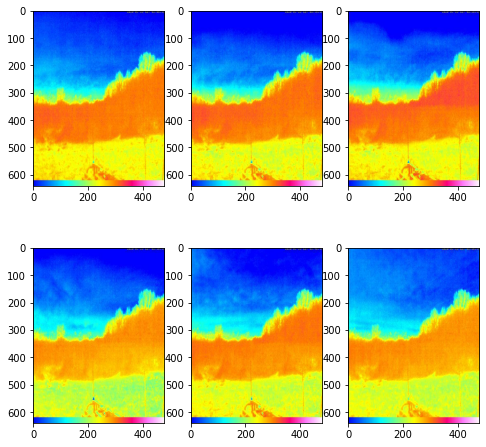

In [8]:
fig=plt.figure(figsize=(8,8))
columns = 3
rows = 2
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_flir[0,i-1,:,:,:].reshape(img_w,img_h,3))
plt.show()

### Plot top batch
Does the code not work, the images are black? Nope, the cameras were offline at this time.

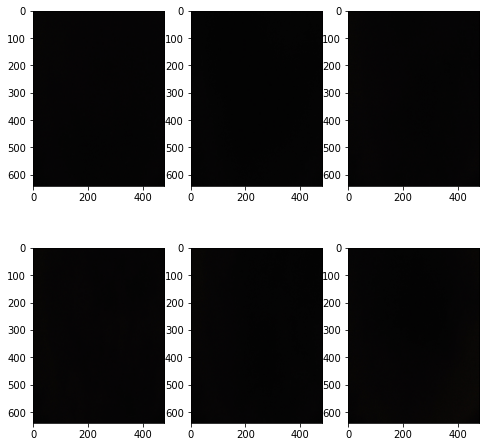

In [9]:
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 2
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_top[0,i-1,:,:,:].reshape(img_w,img_h,3))
plt.show()

### Plot bottom batch

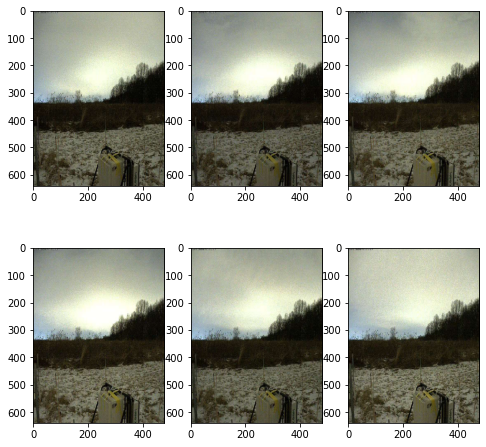

In [10]:
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 2
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_bottom[0,i-1,:,:,:].reshape(img_w,img_h,3))
plt.show()

### Target value

In [11]:
print("Target value: ",y)

Target value:  [[1. 0. 0.]]
